# Model To Predict Injury Based on Momentum

In [157]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
import os
import glob
import sys
sys.path.insert(0, '../scripts/')
from football_field import create_football_field
from plots import plot_play
import math

%matplotlib inline
pd.options.display.max_columns = 100

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [45]:
momentum = pd.read_parquet('../working/momentum-allplays-1yarddistance.parquet')

In [179]:
vr = pd.read_csv('../working/video_review-detailed.csv')

In [49]:
vr.head()

,Season_Year,GameKey,PlayID,GSISID,Player_Activity_Derived,Turnover_Related,Primary_Impact_Type,Primary_Partner_GSISID,Primary_Partner_Activity_Derived,Friendly_Fire,Position_Injured,Jersey_Number_Injured,Position_Primary_Partner,Jersey_Number_Primary_Partner
0,2016,5,3129,31057,Tackling,No,Helmet-to-body,32482,Tackled,No,RB,"25, 25o",WR,"2, 45"
1,2016,21,2587,29343,Blocked,No,Helmet-to-helmet,31059,Blocking,No,WR,86,FS,"28, 34d, 42"
2,2016,29,538,31023,Tackling,No,Helmet-to-body,31941,Tackled,No,WR,81,WR,80
3,2016,45,1212,33121,Tackling,No,Helmet-to-body,28249,Tackled,No,ILB,93,WR,"15, 16, 10, 11"
4,2016,54,1045,32444,Blocked,No,Helmet-to-body,31756,Blocked,Yes,OLB,41,S,"39d, 39"


In [51]:
momentum = momentum.rename(columns={'gsisid': 'GSISID', 'gsisid_partner': 'Primary_Partner_GSISID'})

In [53]:
injured_momentum = pd.merge(momentum, vr)

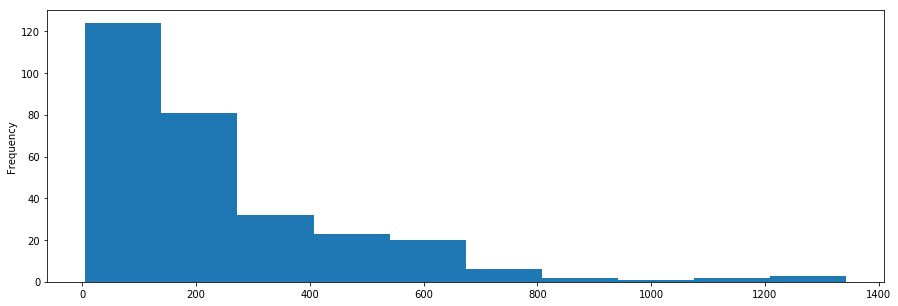

In [57]:
injured_momentum['opp_momentum'].plot(kind='hist', figsize=(15, 5))

In [70]:
max_opp_momentum_on_inj = injured_momentum.groupby(['Season_Year','GameKey','PlayID','GSISID','Primary_Partner_GSISID','role','role_partner']).max()['opp_momentum'].reset_index().sort_values('opp_momentum')

In [72]:
inj_at_max_opp_forces = pd.merge(max_opp_momentum_on_inj, momentum)

(2016, 5, 3129)


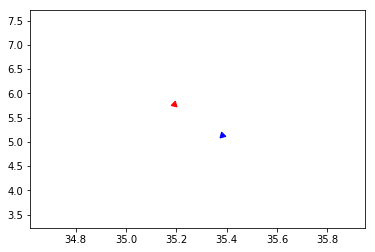

In [152]:
for i, d in inj_at_max_opp_forces.groupby(['Season_Year','GameKey','PlayID']):
    print(i)
    #fig, ax = create_football_field()
    #fig, ax = plt.subplots(figsize=(10, 10))
    plt.plot(d['x'].tolist(), d['y'].tolist(), marker=(3, 0, d['dir'].tolist()), markersize=7, color='red')
    plt.plot(d['x_partner'].tolist(), d['y_partner'].tolist(), marker=(3, 0, d['dir_partner'].tolist()), markersize=7, color='blue')
#     ax.set_xlim(30, 40)
#     plt.ylim(0, 10)
    #d.plot(x='x',y='y', kind='scatter', ax=ax)
    #d.plot(x='x_partner',y='y_partner', kind='scatter', ax=ax, style='<')
    plt.margins(3, 3)

    plt.show()
    break

In [153]:
play = pd.read_csv('../working/playlevel/during_play/2016-5-3129.csv')

In [159]:
def touch(fname, times=None):
        with open(fname, 'a'):
                    os.utime(fname, times)


def calculateDistance(x1, y1, x2, y2):
    dist = math.sqrt((x2 - x1)**2 + (y2 - y1)**2)
    return dist


def cart2pol(x, y):
    rho = np.sqrt(x**2 + y**2)
    phi = np.arctan2(y, x)
    return(rho, phi)


def pol2cart(rho, phi):
    x = rho * np.cos(phi)
    y = rho * np.sin(phi)
    return(x, y)


def add_play_physics(play):
    # Format columns
    play['time'] = pd.to_datetime(play['time'])
    # Distance
    play['dis_meters'] = play['dis'] / 1.0936  # Add distance in meters
    # Speed
    play['dis_meters'] / 0.01
    play['v_mps'] = play['dis_meters'] / 0.1
    # Angles to radians
    play['dir_radians'] = play['dir'].apply(math.radians)
    play['o_radians'] = play['o'].apply(math.radians)
    average_weight_nfl_pounds = 245.86
    average_weight_nfl_kg = average_weight_nfl_pounds * 0.45359237
    # http://webpages.uidaho.edu/~renaes/251/HON/Student%20PPTs/Avg%20NFL%20ht%20wt.pdf
    play['momentum'] = play['v_mps'] * average_weight_nfl_kg
    play['momentum_x'] = pol2cart(play['momentum'], play['dir_radians'])[0]
    play['momentum_y'] = pol2cart(play['momentum'], play['dir_radians'])[1]
    return play

In [160]:
play = add_play_physics(play)

In [165]:
playexpanded = pd.merge(play, play, on=['season_year','gamekey','playid','time'], suffixes=('','_partner'))

In [167]:
playexpanded['opp_momentum'] = np.sqrt(np.square(
    playexpanded['momentum_x'] - playexpanded['momentum_x_partner']) +
    np.square(playexpanded['momentum_y'] - playexpanded['momentum_y_partner']))

In [209]:
playexpanded['dist'] = np.sqrt((playexpanded['x'] - playexpanded['x_partner']).apply(np.square) + (playexpanded['y'] - playexpanded['y_partner']).apply(np.square))

In [213]:
playexpanded['risk_factor'] = playexpanded['opp_momentum'] / playexpanded['dist']

In [197]:
calculateDistance(playexpanded['x'], playexpanded['y'], playexpanded['x_partner'], playexpanded['y_partner'])

TypeError: cannot convert the series to <class 'float'>

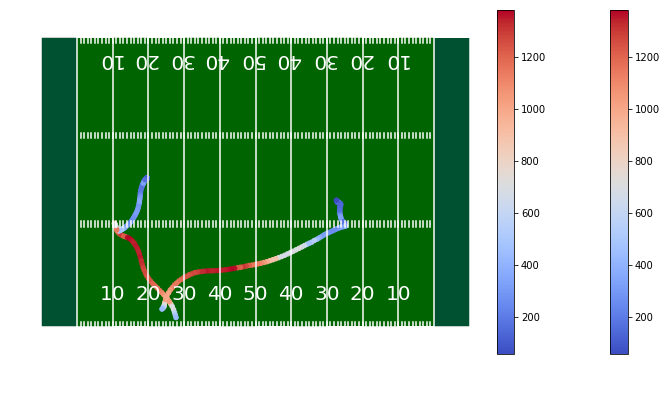

In [190]:
fig, ax = create_football_field()
df = playexpanded.loc[(playexpanded['role'] == 'PLW') & (playexpanded['role_partner'] == 'PR')]

df[['time','role','role_partner','v_mps','v_mps_partner','opp_momentum','x','y','x_partner','y_partner']] \
    .plot(kind='scatter', x='x',y='y',
          c=df['opp_momentum'].tolist(),
         cmap='coolwarm',
         ax=ax)

df[['time','role','role_partner','v_mps','v_mps_partner','opp_momentum','x','y','x_partner','y_partner']] \
    .plot(kind='scatter', x='x_partner',y='y_partner',
          c=df['opp_momentum'].tolist(),
         cmap='coolwarm',
         ax=ax)

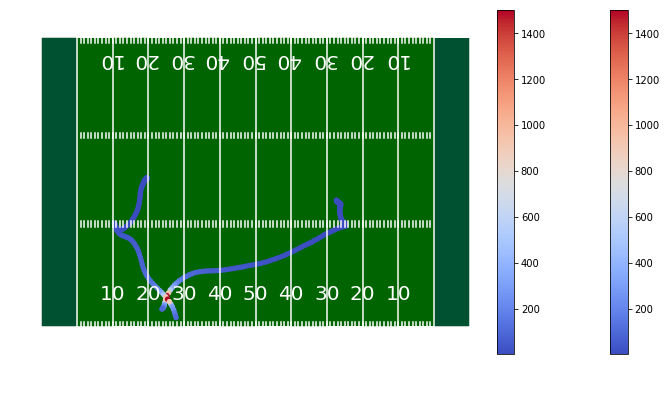

In [214]:
fig, ax = create_football_field()
df = playexpanded.loc[(playexpanded['role'] == 'PLW') & (playexpanded['role_partner'] == 'PR')]

df[['time','role','role_partner','v_mps','v_mps_partner','opp_momentum','x','y','x_partner','y_partner']] \
    .plot(kind='scatter', x='x',y='y',
          c=df['risk_factor'].tolist(),
         cmap='coolwarm',
         ax=ax)

df[['time','role','role_partner','v_mps','v_mps_partner','opp_momentum','x','y','x_partner','y_partner']] \
    .plot(kind='scatter', x='x_partner',y='y_partner',
          c=df['risk_factor'].tolist(),
         cmap='coolwarm',
         ax=ax)

In [220]:
playexpanded.sort_values('risk_factor', ascending=False).head()

,Unnamed: 0,season_year,gamekey,playid,gsisid,time,x,y,dis,o,dir,event,number,position,role,generalized_role,punting_returning_team,gsisid_injured,player_activity_derived,turnover_related,primary_impact_type,primary_partner_gsisid,primary_partner_activity_derived,friendly_fire,ball_snap,line_set,penalty_flag,play_submit,punt,punt_play,punt_received,tackle,mph,injured_player,primary_partner_player,left_to_right,dis_meters,v_mps,dir_radians,o_radians,momentum,momentum_x,momentum_y,Unnamed: 0_partner,gsisid_partner,x_partner,y_partner,dis_partner,o_partner,dir_partner,event_partner,number_partner,position_partner,role_partner,generalized_role_partner,punting_returning_team_partner,gsisid_injured_partner,player_activity_derived_partner,turnover_related_partner,primary_impact_type_partner,primary_partner_gsisid_partner,primary_partner_activity_derived_partner,friendly_fire_partner,ball_snap_partner,line_set_partner,penalty_flag_partner,play_submit_partner,punt_partner,punt_play_partner,punt_received_partner,tackle_partner,mph_partner,injured_player_partner,primary_partner_player_partner,left_to_right_partner,dis_meters_partner,v_mps_partner,dir_radians_partner,o_radians_partner,momentum_partner,momentum_x_partner,momentum_y_partner,opp_momentum,dist,risk_factor
46388,5267,2016,5,3129,32519.0,2016-08-12 02:07:47.300,40.259998,15.360000,0.32,283.279999,99.750000,NaN,41,LB,PDR3,Defensive_Lineman,Returning_Team,31057,Tackling,No,Helmet-to-body,32482.0,Tackled,No,2016-08-12 02:07:37.000,2016-08-12 02:07:31.400,2016-08-12 02:07:50.900,2016-08-12 02:07:51.900,2016-08-12 02:07:39.000,2016-08-12 02:07:25.100,2016-08-12 02:07:43.400,2016-08-12 02:07:48.300,6.545454,False,False,False,0.292612,2.926116,1.740966,4.944169,326.321046,-55.262307,321.607684,497,28284.0,40.240002,15.350000,0.26,74.800003,125.389999,NaN,48,LS,PLS,Punting_Longsnapper,Punting_Team,31057,Tackling,No,Helmet-to-body,32482.0,Tackled,No,2016-08-12 02:07:37.000,2016-08-12 02:07:31.400,2016-08-12 02:07:50.900,2016-08-12 02:07:51.900,2016-08-12 02:07:39.000,2016-08-12 02:07:25.100,2016-08-12 02:07:43.400,2016-08-12 02:07:48.300,5.318182,False,False,False,0.237747,2.377469,2.188468,1.305506,265.135846,-153.550479,216.146403,144.161877,0.022357,6448.074423
46010,497,2016,5,3129,28284.0,2016-08-12 02:07:47.300,40.240002,15.350000,0.26,74.800003,125.389999,NaN,48,LS,PLS,Punting_Longsnapper,Punting_Team,31057,Tackling,No,Helmet-to-body,32482.0,Tackled,No,2016-08-12 02:07:37.000,2016-08-12 02:07:31.400,2016-08-12 02:07:50.900,2016-08-12 02:07:51.900,2016-08-12 02:07:39.000,2016-08-12 02:07:25.100,2016-08-12 02:07:43.400,2016-08-12 02:07:48.300,5.318182,False,False,False,0.237747,2.377469,2.188468,1.305506,265.135846,-153.550479,216.146403,5267,32519.0,40.259998,15.360000,0.32,283.279999,99.750000,NaN,41,LB,PDR3,Defensive_Lineman,Returning_Team,31057,Tackling,No,Helmet-to-body,32482.0,Tackled,No,2016-08-12 02:07:37.000,2016-08-12 02:07:31.400,2016-08-12 02:07:50.900,2016-08-12 02:07:51.900,2016-08-12 02:07:39.000,2016-08-12 02:07:25.100,2016-08-12 02:07:43.400,2016-08-12 02:07:48.300,6.545454,False,False,False,0.292612,2.926116,1.740966,4.944169,326.321046,-55.262307,321.607684,144.161877,0.022357,6448.074423
11397,1982,2016,5,3129,32776.0,2016-08-12 02:07:44.900,26.559999,20.350000,0.42,151.160004,221.190002,NaN,"32d, 32","CB, CB",GR,Gunner,Punting_Team,31057,Tackling,No,Helmet-to-body,32482.0,Tackled,No,2016-08-12 02:07:37.000,2016-08-12 02:07:31.400,2016-08-12 02:07:50.900,2016-08-12 02:07:51.900,2016-08-12 02:07:39.000,2016-08-12 02:07:25.100,2016-08-12 02:07:43.400,2016-08-12 02:07:48.300,8.590909,False,False,False,0.384053,3.840527,3.860494,2.638240,428.296370,-322.305795,-282.058069,3353,31697.0,26.610001,20.309999,0.08,14.080000,292.350006,NaN,87,WR,PFB,PuntFullBack,Punting_Team,31057,Tackling,No,Helmet-to-body,32482.0,Tackled,No,2016-08-12 02:07:37.000,2016-08-12 02:07:31.400,2016-08-12 02:07:50.900,2016-08-12 02:07:51.900,2016-08-12 02:07:39.000,2016-08-12 02:07:25.100,2016

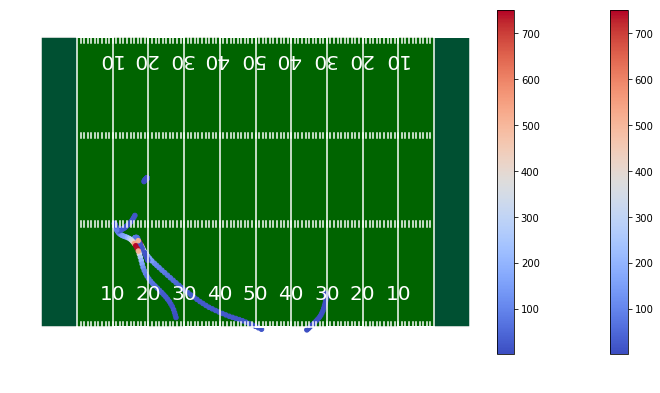

In [223]:
fig, ax = create_football_field()
df = playexpanded.loc[(playexpanded['role'] == 'GL') & (playexpanded['role_partner'] == 'PR')]

df[['time','role','role_partner','v_mps','v_mps_partner','opp_momentum','x','y','x_partner','y_partner']] \
    .plot(kind='scatter', x='x',y='y',
          c=df['risk_factor'].tolist(),
         cmap='coolwarm',
         ax=ax)

df[['time','role','role_partner','v_mps','v_mps_partner','opp_momentum','x','y','x_partner','y_partner']] \
    .plot(kind='scatter', x='x_partner',y='y_partner',
          c=df['risk_factor'].tolist(),
         cmap='coolwarm',
         ax=ax)

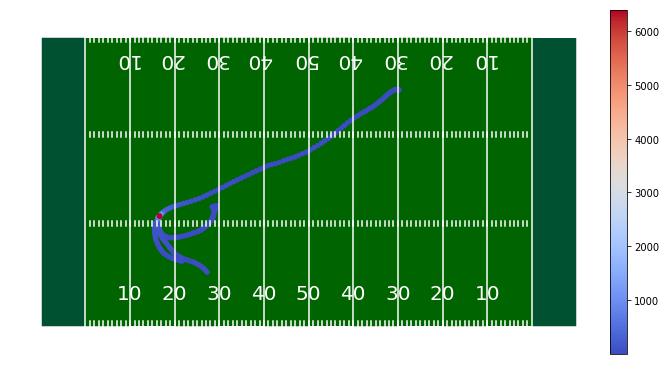

In [233]:
fig, ax = create_football_field()
df = playexpanded.loc[(playexpanded['role'] == 'PFB') & (playexpanded['role_partner'] == 'GR') |
                      (playexpanded['role'] == 'GR') & (playexpanded['role_partner'] == 'PFB')]
df = df.sort_values('risk_factor')
df[['time','role','role_partner','v_mps','v_mps_partner','opp_momentum','x','y','x_partner','y_partner']] \
    .plot(kind='scatter', x='x',y='y',
          c=df['risk_factor'].tolist(),
         cmap='coolwarm',
         ax=ax)

In [228]:
playexpanded[['time','role','role_partner','opp_momentum','risk_factor']].sort_values('risk_factor', ascending=False).head()

,time,role,role_partner,opp_momentum,risk_factor
46388,2016-08-12 02:07:47.300,PDR3,PLS,144.161877,6448.074423
46010,2016-08-12 02:07:47.300,PLS,PDR3,144.161877,6448.074423
11397,2016-08-12 02:07:44.900,GR,PFB,409.300229,6392.049345
11502,2016-08-12 02:07:44.900,PFB,GR,409.300229,6392.049345
45526,2016-08-12 02:07:47.200,PLS,PDR3,158.078961,3161.627453


In [ ]:
playexpanded[['role','role_partner','opp_momentum','risk_factor']].sort_values('risk_factor', ascending=False).head()

In [234]:
play2 = pd.read_parquet('../working/playlevel/momentum_risk/2016-149-3663-risk.parquet')

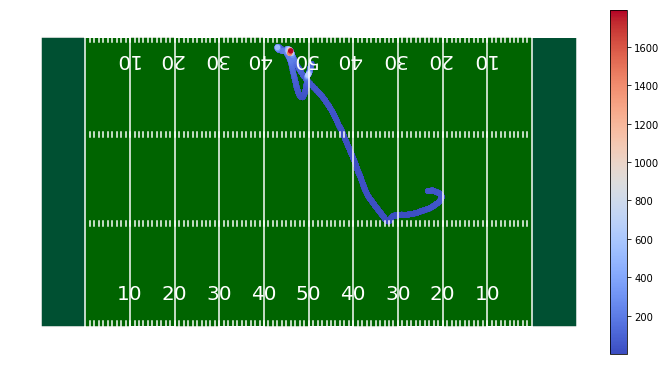

In [239]:
df = play2.loc[play2['injured_player'] == True]
fig, ax = create_football_field()
df = df.sort_values('risk_factor')
df[['time','role','role_partner','v_mps','v_mps_partner','opp_momentum','x','y','x_partner','y_partner']] \
    .plot(kind='scatter', x='x',y='y',
          c=df['risk_factor'].tolist(),
         cmap='coolwarm',
         ax=ax)

In [263]:
play2.head()

,season_year,gamekey,playid,gsisid,time,x,y,dis,o,dir,event,number,position,role,generalized_role,punting_returning_team,gsisid_injured,player_activity_derived,turnover_related,primary_impact_type,primary_partner_gsisid,primary_partner_activity_derived,friendly_fire,ball_snap,line_set,play_submit,punt,punt_play,punt_received,tackle,mph,injured_player,primary_partner_player,left_to_right,dis_meters,v_mps,dir_radians,o_radians,momentum,momentum_x,momentum_y,gsisid_partner,x_partner,y_partner,dis_partner,o_partner,dir_partner,event_partner,number_partner,position_partner,role_partner,generalized_role_partner,punting_returning_team_partner,gsisid_injured_partner,player_activity_derived_partner,turnover_related_partner,primary_impact_type_partner,primary_partner_gsisid_partner,primary_partner_activity_derived_partner,friendly_fire_partner,ball_snap_partner,line_set_partner,play_submit_partner,punt_partner,punt_play_partner,punt_received_partner,tackle_partner,mph_partner,injured_player_partner,primary_partner_player_partner,left_to_right_partner,dis_meters_partner,v_mps_partner,dir_radians_partner,o_radians_partner,momentum_partner,momentum_x_partner,momentum_y_partner,dist,opp_momentum,risk_factor
1,2016,149,3663,31596,2016-10-16 19:37:39.300,96.019997,20.690001,0.16,343.059998,69.559998,None,55,MLB,PDR2,Defensive_Lineman,Returning_Team,28128,Blocking,No,Helmet-to-body,29629.0,Blocked,No,2016-10-16 19:37:52.300,2016-10-16 19:37:51.000,2016-10-16 19:38:11.300,2016-10-16 19:37:54.500,2016-10-16 19:37:37.900,2016-10-16 19:37:59.300,2016-10-16 19:38:04.700,3.272727,False,False,False,0.146306,1.463058,1.214051,5.987526,163.160523,56.979954,152.887675,25406,94.320000,28.389999,0.16,18.020000,99.139999,None,"22, 33","FS, FS",PDL1,Defensive_Lineman,Returning_Team,28128,Blocking,No,Helmet-to-body,29629.0,Blocked,No,2016-10-16 19:37:52.300,2016-10-16 19:37:51.000,2016-10-16 19:38:11.300,2016-10-16 19:37:54.500,2016-10-16 19:37:37.900,2016-10-16 19:37:59.300,2016-10-16 19:38:04.700,3.272727,False,False,False,0.146306,1.463058,1.730319,0.314508,163.160523,-25.917619,161.088899,7.885428,83.302267,10.564077
2,2016,149,3663,31596,2016-10-16 19:37:39.300,96.019997,20.690001,0.16,343.059998,69.559998,None,55,MLB,PDR2,Defensive_Lineman,Returning_Team,28128,Blocking,No,Helmet-to-body,29629.0,Blocked,No,2016-10-16 19:37:52.300,2016-10-16 19:37:51.000,2016-10-16 19:38:11.300,2016-10-16 19:37:54.500,2016-10-16 19:37:37.900,2016-10-16 19:37:59.300,2016-10-16 19:38:04.700,3.272727,False,False,False,0.146306,1.463058,1.214051,5.987526,163.160523,56.979954,152.887675,30463,91.919998,23.910000,0.21,9.430000,93.660004,None,"53, 56","OLB, OLB",PDL2,Defensive_Lineman,Returning_Team,28128,Blocking,No,Helmet-to-body,29629.0,Blocked,No,2016-10-16 19:37:52.300,2016-10-16 19:37:51.000,2016-10-16 19:38:11.300,2016-10-16 19:37:54.500,2016-10-16 19:37:37.900,2016-10-16 19:37:59.300,2016-10-16 19:38:04.700,4.295454,False,False,False,0.192026,1.920263,1.634675,0.164585,214.148185,-13.670295,213.711413,5.213289,93.225451,17.882272
3,2016,149,3663,31596,2016-10-16 19:37:39.300,96.019997,20.690001,0.16,343.059998,69.559998,None,55,MLB,PDR2,Defensive_Lineman,Returning_Team,28128,Blocking,No,Helmet-to-body,29629.0,Blocked,No,2016-10-16 19:37:52.300,2016-10-16 19:37:51.000,2016-10-16 19:38:11.300,2016-10-16 19:37:54.500,2016-10-16 19:37:37.900,2016-10-16 19:37:59.300,2016-10-16 19:38:04.700,3.272727,False,False,False,0.146306,1.463058,1.214051,5.987526,163.160523,56.979954,152.887675,27853,93.519997,35.849998,0.16,323.709991,40.849998,None,21,CB,VL,Jammer,Returning_Team,28128,Blocking,No,Helmet-to-body,29629.0,Blocked,No,2016-10-16 19:37:52.300,2016-10-16 19:37:51.000,2016-10-16 19:38:11.300,2016-10-16 19:37:54.500,2016-10-16 19:37:37.900,2016-10-16 19:37:59.300,2016-10-16 19:38:04.700,3.272727,False,False,False,0.146306,1.463058,0.712967,5.649805,163.160523,123.418628,106.720188,15.364750,80.904477,5.265590
4,2016,149,3663,31596,2016-10-16 19:37:39.300,96.019997,20.690001,0.

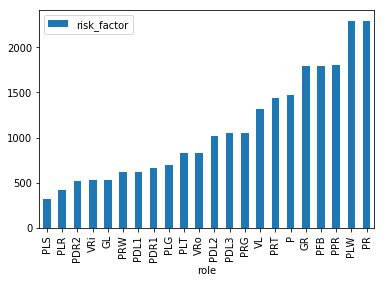

In [257]:
pd.merge(play2.groupby(['season_year', 'gamekey', 'playid', 'gsisid'])['risk_factor'].max().reset_index(),
         play2, how='left')[['role','risk_factor']].sort_values('risk_factor').plot(x='role', kind='bar')

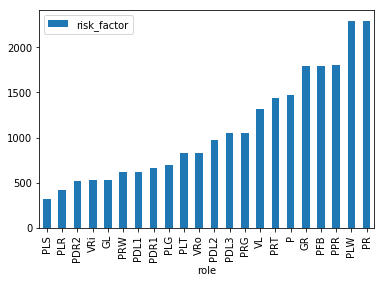

In [270]:
pd.merge(play2.loc[play2['dist'] < 1].groupby(['season_year', 'gamekey', 'playid', 'gsisid'])['risk_factor'].max().reset_index(),
         play2.loc[play2['dist'] < 1], how='left')[['role','risk_factor']].sort_values('risk_factor').plot(x='role', kind='bar')

In [297]:
play2.columns

Index(['season_year', 'gamekey', 'playid', 'gsisid', 'time', 'x', 'y', 'dis',
       'o', 'dir', 'event', 'number', 'position', 'role', 'generalized_role',
       'punting_returning_team', 'gsisid_injured', 'player_activity_derived',
       'turnover_related', 'primary_impact_type', 'primary_partner_gsisid',
       'primary_partner_activity_derived', 'friendly_fire', 'ball_snap',
       'line_set', 'play_submit', 'punt', 'punt_play', 'punt_received',
       'tackle', 'mph', 'injured_player', 'primary_partner_player',
       'left_to_right', 'dis_meters', 'v_mps', 'dir_radians', 'o_radians',
       'momentum', 'momentum_x', 'momentum_y', 'gsisid_partner', 'x_partner',
       'y_partner', 'dis_partner', 'o_partner', 'dir_partner', 'event_partner',
       'number_partner', 'position_partner', 'role_partner',
       'generalized_role_partner', 'punting_returning_team_partner',
       'gsisid_injured_partner', 'player_activity_derived_partner',
       'turnover_related_partner', 'primary_im

In [300]:
pd.merge(play2.groupby(['season_year', 'gamekey', 'playid', 'gsisid','role',
                        'role_partner','injured_player','primary_partner_player',
                        'injured_player_partner','primary_partner_player_partner'])['risk_factor'].max().reset_index(),
         play2, how='left')[['role','role_partner','risk_factor','injured_player',
                             'primary_partner_player','injured_player_partner',
                             'primary_partner_player_partner']].sort_values('risk_factor')

,role,role_partner,risk_factor,injured_player,primary_partner_player,injured_player_partner,primary_partner_player_partner
49,P,PFB,26.530717,False,False,True,False
128,PFB,P,26.530717,True,False,False,False
155,PLW,PFB,32.605671,False,False,True,False
138,PFB,PLW,32.605671,True,False,False,False
249,PLG,VL,33.764842,False,False,False,False
114,VL,PLG,33.764842,False,False,False,False
407,VRo,PFB,34.468676,False,False,True,False
146,PFB,VRo,34.468676,True,False,False,False
260,PLT,PFB,34.705592,False,False,True,False
137,PFB,PLT,34.705592,True,False,False,False


In [276]:
play2.groupby(['season_year', 'gamekey', 'playid', 'gsisid','role'])['risk_factor'].mean()

season_year  gamekey  playid  gsisid  role
2016         149      3663    25396   PR      25.654193
                              25406   PDL1    23.328000
                              27114   P       22.386962
                              27197   PLS     28.530243
                              27796   PLR     32.067344
                              27853   VL      17.578684
                              28128   PFB     20.195704
                              28834   PLW     29.687892
                              29205   PRW     23.012033
                              29629   PRT     27.875819
                              29731   PDR1    27.578091
                              30216   PLG     31.929937
                              30392   PLT     32.104122
                              30463   PDL2    27.761247
                              30675   VRi     27.145641
                              30802   GL      21.695217
                              31255   PRG     30.738049
     